### imports

In [1]:

import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

###  Hybrid Model Preparation (XGBoost + LSTM)
Data Splitting

In [9]:
import pandas as pd
# Load the fraud data
fraud_data = pd.read_csv('../data/fraud_data.csv')
# Optional: Check the data
print("Data shape:", fraud_data.shape)
print("\nColumns:", fraud_data.columns.tolist())

Data shape: (151112, 11)

Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']


In [17]:
import numpy as np
import tensorflow as tf

def create_transaction_sequences(df, seq_length=10):
    """
    Create sequences of transactions based on time order, not per user
    """
    # Preprocess the data
    df = df.copy()
    
    # Convert timestamps to numeric
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    
    # Sort all transactions by time
    df = df.sort_values('purchase_time')
    
    # Convert categorical variables to numeric
    categorical_cols = ['source', 'browser', 'sex']
    for col in categorical_cols:
        df[col] = pd.Categorical(df[col]).codes.astype('float32')
    
    # Convert ip_address to numeric hash and normalize
    df['ip_address'] = pd.util.hash_array(df['ip_address'].values).astype('float32')
    df['ip_address'] = (df['ip_address'] - df['ip_address'].mean()) / df['ip_address'].std()
    
    # Convert device_id to numeric and normalize
    df['device_id'] = pd.Categorical(df['device_id']).codes.astype('float32')
    
    # Normalize numeric columns
    numeric_cols = ['purchase_value', 'age']
    for col in numeric_cols:
        df[col] = ((df[col] - df[col].mean()) / df[col].std()).astype('float32')
    
    # Ensure class is float32
    df['class'] = df['class'].astype('float32')
    
    # Select features (excluding user_id and timestamps)
    feature_cols = ['purchase_value', 'device_id', 'source', 'browser', 
                   'sex', 'age', 'ip_address', 'class']
    
    # Create sequences from all transactions
    sequences = []
    features = df[feature_cols].values.astype('float32')
    
    # Create overlapping sequences
    for i in range(0, len(features) - seq_length + 1):
        sequence = features[i:i+seq_length]
        sequences.append(sequence)
    
    return np.array(sequences, dtype='float32')

# Create and split the sequences
try:
    # Create sequences (using 10 transactions per sequence)
    seq_data = create_transaction_sequences(fraud_data, seq_length=10)
    print("Sequence data shape:", seq_data.shape)
    
    # Split into features and labels
    X_seq = seq_data[:, :-1, :-1]  # All sequences except last timestamp, all features except class
    y_seq = seq_data[:, -1, -1]    # Class label from last timestamp
    
    # Ensure data types are correct
    X_seq = X_seq.astype('float32')
    y_seq = y_seq.astype('float32')
    
    print("\nData shapes:")
    print(f"X_seq shape: {X_seq.shape}")
    print(f"y_seq shape: {y_seq.shape}")
    print(f"X_seq dtype: {X_seq.dtype}")
    print(f"y_seq dtype: {y_seq.dtype}")
    
    # Build and train LSTM model
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    lstm_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    # Train model
    history = lstm_model.fit(
        X_seq, y_seq,
        epochs=10,
        batch_size=256,
        validation_split=0.2,
        verbose=1
    )
    
    # Print training results
    print("\nTraining completed!")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final validation AUC: {history.history['val_auc'][-1]:.4f}")

    # Plot training history
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {str(e)}")
    print("\nTroubleshooting tips:")
    print("1. Check the number of total transactions")
    print("2. Verify data types of all columns")
    print("3. Look for any missing or invalid values")

Sequence data shape: (151103, 10, 8)

Data shapes:
X_seq shape: (151103, 9, 7)
y_seq shape: (151103,)
X_seq dtype: float32
y_seq dtype: float32
Epoch 1/10


2025-03-10 13:32:32.395322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-10 13:32:34.449955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:32:34.844843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:32:38.259223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


473/473 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8945 - auc_1: 0.4952

2025-03-10 13:32:46.476674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:32:46.543595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


473/473 [==============================] - 15s 18ms/step - loss: 0.3482 - accuracy: 0.8945 - auc_1: 0.4952 - val_loss: 0.2156 - val_accuracy: 0.9540 - val_auc_1: 0.5019
Epoch 2/10
473/473 [==============================] - 7s 15ms/step - loss: 0.3416 - accuracy: 0.8946 - auc_1: 0.4986 - val_loss: 0.2399 - val_accuracy: 0.9540 - val_auc_1: 0.5008
Epoch 3/10
473/473 [==============================] - 7s 15ms/step - loss: 0.3400 - accuracy: 0.8946 - auc_1: 0.5055 - val_loss: 0.2397 - val_accuracy: 0.9540 - val_auc_1: 0.5029
Epoch 4/10
473/473 [==============================] - 7s 15ms/step - loss: 0.3395 - accuracy: 0.8946 - auc_1: 0.5054 - val_loss: 0.2272 - val_accuracy: 0.9540 - val_auc_1: 0.5005
Epoch 5/10
473/473 [==============================] - 7s 14ms/step - loss: 0.3396 - accuracy: 0.8946 - auc_1: 0.4960 - val_loss: 0.2395 - val_accuracy: 0.9540 - val_auc_1: 0.5016
Epoch 6/10
473/473 [==============================] - 7s 14ms/step - loss: 0.3394 - accuracy: 0.8946 - auc_1: 0.499

 ### Hybrid Model Implementation

Data shape: (151112, 11)

Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']
Creating sequences...
Sequence data shape: (151103, 10, 8)

Data shapes:
X_seq shape: (151103, 9, 7)
y_seq shape: (151103,)
X_seq dtype: float32
y_seq dtype: float32

Building LSTM model...
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2025-03-10 13:46:13.459284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-10 13:46:13.459832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Training LSTM model...
Epoch 1/10


2025-03-10 13:46:14.049777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-10 13:46:14.903290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:46:15.085921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:46:15.564754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


473/473 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8814 - auc: 0.4978

2025-03-10 13:46:22.513212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:46:22.586933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


473/473 [==============================] - 10s 17ms/step - loss: 0.3659 - accuracy: 0.8814 - auc: 0.4978 - val_loss: 0.2209 - val_accuracy: 0.9540 - val_auc: 0.5013
Epoch 2/10
473/473 [==============================] - 7s 15ms/step - loss: 0.3420 - accuracy: 0.8946 - auc: 0.5030 - val_loss: 0.2215 - val_accuracy: 0.9540 - val_auc: 0.5008
Epoch 3/10
473/473 [==============================] - 8s 16ms/step - loss: 0.3407 - accuracy: 0.8946 - auc: 0.5049 - val_loss: 0.2361 - val_accuracy: 0.9540 - val_auc: 0.5024
Epoch 4/10
473/473 [==============================] - 7s 14ms/step - loss: 0.3402 - accuracy: 0.8946 - auc: 0.4995 - val_loss: 0.2341 - val_accuracy: 0.9540 - val_auc: 0.5016
Epoch 5/10
473/473 [==============================] - 6s 14ms/step - loss: 0.3401 - accuracy: 0.8946 - auc: 0.4971 - val_loss: 0.2282 - val_accuracy: 0.9540 - val_auc: 0.5009
Epoch 6/10
473/473 [==============================] - 6s 14ms/step - loss: 0.3392 - accuracy: 0.8946 - auc: 0.5014 - val_loss: 0.2237 -

2025-03-10 13:47:24.244108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:47:24.330633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4722/4722 [==============================] - 15s 3ms/step

Splitting data for XGBoost...

Training XGBoost model...
[0]	validation_0-logloss:0.69296	validation_1-logloss:0.69299
[1]	validation_0-logloss:0.69278	validation_1-logloss:0.69284
[2]	validation_0-logloss:0.69264	validation_1-logloss:0.69270
[3]	validation_0-logloss:0.69246	validation_1-logloss:0.69254
[4]	validation_0-logloss:0.69235	validation_1-logloss:0.69245
[5]	validation_0-logloss:0.69221	validation_1-logloss:0.69232
[6]	validation_0-logloss:0.69202	validation_1-logloss:0.69215
[7]	validation_0-logloss:0.69186	validation_1-logloss:0.69201
[8]	validation_0-logloss:0.69170	validation_1-logloss:0.69187
[9]	validation_0-logloss:0.69154	validation_1-logloss:0.69174
[10]	validation_0-logloss:0.69137	validation_1-logloss:0.69160
[11]	validation_0-logloss:0.69123	validation_1-logloss:0.69149
[12]	validation_0-logloss:0.69105	validation_1-logloss:0.69134
[13]	validation_0-logloss:0.69092	validation_1-logloss:0.69123
[14]	validat

/Users/zelalemtegene/envs/shared_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:47:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-logloss:0.68901	validation_1-logloss:0.68953
[28]	validation_0-logloss:0.68889	validation_1-logloss:0.68944
[29]	validation_0-logloss:0.68875	validation_1-logloss:0.68933
[30]	validation_0-logloss:0.68861	validation_1-logloss:0.68921
[31]	validation_0-logloss:0.68845	validation_1-logloss:0.68907
[32]	validation_0-logloss:0.68832	validation_1-logloss:0.68896
[33]	validation_0-logloss:0.68818	validation_1-logloss:0.68884
[34]	validation_0-logloss:0.68805	validation_1-logloss:0.68872
[35]	validation_0-logloss:0.68791	validation_1-logloss:0.68859
[36]	validation_0-logloss:0.68780	validation_1-logloss:0.68850
[37]	validation_0-logloss:0.68767	validation_1-logloss:0.68838
[38]	validation_0-logloss:0.68756	validation_1-logloss:0.68830
[39]	validation_0-logloss:0.68745	validation_1-logloss:0.68821
[40]	validation_0-logloss:0.68737	validation_1-logloss:0.68814
[41]	validation_0-logloss:0.68723	validation_1-logloss:0.68802
[42]	validation_0-logloss:0.68709	validation_1-logloss:

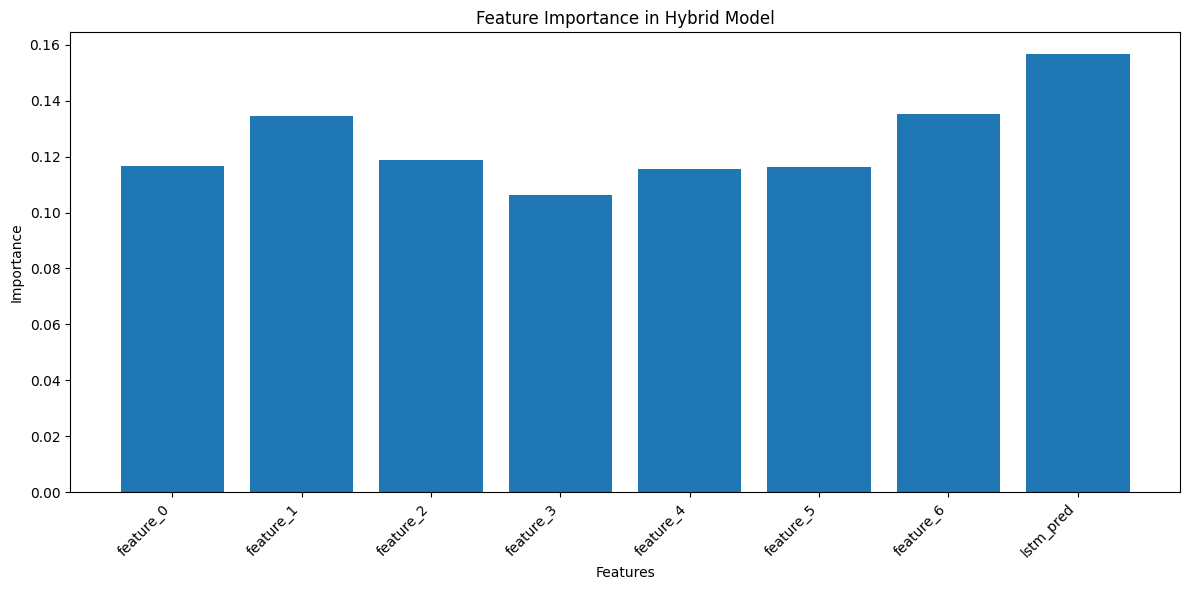


Saving models...

Both models have been saved successfully!
- LSTM model saved as 'lstm_model.h5'
- XGBoost model saved as 'xgb_model.pkl'


In [4]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import joblib

# Load the fraud data
fraud_data = pd.read_csv('../data/fraud_data.csv')
print("Data shape:", fraud_data.shape)
print("\nColumns:", fraud_data.columns.tolist())

def create_transaction_sequences(df, seq_length=10):
    """
    Create sequences of transactions based on time order, not per user
    """
    # Preprocess the data
    df = df.copy()
    
    # Convert timestamps to numeric
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    
    # Sort all transactions by time
    df = df.sort_values('purchase_time')
    
    # Convert categorical variables to numeric
    categorical_cols = ['source', 'browser', 'sex']
    for col in categorical_cols:
        df[col] = pd.Categorical(df[col]).codes.astype('float32')
    
    # Convert ip_address to numeric hash and normalize
    df['ip_address'] = pd.util.hash_array(df['ip_address'].values).astype('float32')
    df['ip_address'] = (df['ip_address'] - df['ip_address'].mean()) / df['ip_address'].std()
    
    # Convert device_id to numeric and normalize
    df['device_id'] = pd.Categorical(df['device_id']).codes.astype('float32')
    
    # Normalize numeric columns
    numeric_cols = ['purchase_value', 'age']
    for col in numeric_cols:
        df[col] = ((df[col] - df[col].mean()) / df[col].std()).astype('float32')
    
    # Ensure class is float32
    df['class'] = df['class'].astype('float32')
    
    # Select features (excluding user_id and timestamps)
    feature_cols = ['purchase_value', 'device_id', 'source', 'browser', 
                   'sex', 'age', 'ip_address', 'class']
    
    # Create sequences from all transactions
    sequences = []
    features = df[feature_cols].values.astype('float32')
    
    # Create overlapping sequences
    for i in range(0, len(features) - seq_length + 1):
        sequence = features[i:i+seq_length]
        sequences.append(sequence)
    
    return np.array(sequences, dtype='float32')

try:
    # Create sequences
    print("Creating sequences...")
    seq_data = create_transaction_sequences(fraud_data, seq_length=10)
    print("Sequence data shape:", seq_data.shape)

    # Split into features and labels
    X_seq = seq_data[:, :-1, :-1]  # All sequences except last timestamp, all features except class
    y_seq = seq_data[:, -1, -1]    # Class label from last timestamp

    # Ensure data types are correct
    X_seq = X_seq.astype('float32')
    y_seq = y_seq.astype('float32')

    print("\nData shapes:")
    print(f"X_seq shape: {X_seq.shape}")
    print(f"y_seq shape: {y_seq.shape}")
    print(f"X_seq dtype: {X_seq.dtype}")
    print(f"y_seq dtype: {y_seq.dtype}")

    # Build and train LSTM model
    print("\nBuilding LSTM model...")
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    lstm_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    # Train model
    print("\nTraining LSTM model...")
    history = lstm_model.fit(
        X_seq, y_seq,
        epochs=10,
        batch_size=256,
        validation_split=0.2,
        verbose=1
    )

    print("\nLSTM Training completed!")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

    # Get LSTM predictions
    print("\nGenerating LSTM predictions...")
    lstm_predictions = lstm_model.predict(X_seq)

    # Prepare the original features
    original_features = X_seq[:, -1, :]  # Get the last transaction's features from each sequence

    # Combine original features with LSTM predictions
    X_combined = np.hstack([original_features, lstm_predictions])

    # Split the data
    print("\nSplitting data for XGBoost...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_seq, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_seq
    )

    # Calculate class weights
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

    # Create and train XGBoost model
    print("\nTraining XGBoost model...")
    xgb_model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.01,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        enable_categorical=False,
        use_label_encoder=False
    )

    # Train XGBoost
    xgb_model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True
    )

    # Make predictions
    print("\nGenerating predictions...")
    xgb_predictions = xgb_model.predict(X_test)
    xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_test, xgb_pred_proba)
    print("\nHybrid Model Performance:")
    print("-------------------------")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, xgb_predictions))

    # Feature importance analysis
    feature_names = [f'feature_{i}' for i in range(original_features.shape[1])] + ['lstm_pred']
    importance_dict = dict(zip(feature_names, xgb_model.feature_importances_))

    # Sort feature importances
    sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features:")
    print("------------------------------")
    for feat, imp in sorted_importances[:10]:
        print(f"{feat}: {imp:.4f}")

    # Visualize feature importances
    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, xgb_model.feature_importances_)
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Importance in Hybrid Model')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    # Save both models
    print("\nSaving models...")
    lstm_model.save('lstm_model.h5')
    joblib.dump(xgb_model, 'xgb_model.pkl')

    print("\nBoth models have been saved successfully!")
    print("- LSTM model saved as 'lstm_model.h5'")
    print("- XGBoost model saved as 'xgb_model.pkl'")

except Exception as e:
    print(f"\nError occurred: {str(e)}")
    print("\nTroubleshooting tips:")
    print("1. Check if all required libraries are installed")
    print("2. Verify data file path and contents")
    print("3. Check available memory")
    print("4. Look for any missing or invalid values in the data")

### LightGBM Implementation

In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import joblib

# Load the fraud data
fraud_data = pd.read_csv('../data/fraud_data.csv')
print("Data shape:", fraud_data.shape)
print("\nColumns:", fraud_data.columns.tolist())

def create_transaction_sequences(df, seq_length=10):
    """
    Create sequences of transactions based on time order, not per user
    """
    # Preprocess the data
    df = df.copy()
    
    # Convert timestamps to numeric
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    
    # Sort all transactions by time
    df = df.sort_values('purchase_time')
    
    # Convert categorical variables to numeric
    categorical_cols = ['source', 'browser', 'sex']
    for col in categorical_cols:
        df[col] = pd.Categorical(df[col]).codes.astype('float32')
    
    # Convert ip_address to numeric hash and normalize
    df['ip_address'] = pd.util.hash_array(df['ip_address'].values).astype('float32')
    df['ip_address'] = (df['ip_address'] - df['ip_address'].mean()) / df['ip_address'].std()
    
    # Convert device_id to numeric and normalize
    df['device_id'] = pd.Categorical(df['device_id']).codes.astype('float32')
    
    # Normalize numeric columns
    numeric_cols = ['purchase_value', 'age']
    for col in numeric_cols:
        df[col] = ((df[col] - df[col].mean()) / df[col].std()).astype('float32')
    
    # Ensure class is float32
    df['class'] = df['class'].astype('float32')
    
    # Select features (excluding user_id and timestamps)
    feature_cols = ['purchase_value', 'device_id', 'source', 'browser', 
                   'sex', 'age', 'ip_address', 'class']
    
    # Create sequences from all transactions
    sequences = []
    features = df[feature_cols].values.astype('float32')
    
    # Create overlapping sequences
    for i in range(0, len(features) - seq_length + 1):
        sequence = features[i:i+seq_length]
        sequences.append(sequence)
    
    return np.array(sequences, dtype='float32')

try:
    # Create sequences
    print("Creating sequences...")
    seq_data = create_transaction_sequences(fraud_data, seq_length=10)
    print("Sequence data shape:", seq_data.shape)

    # Split into features and labels
    X_seq = seq_data[:, :-1, :-1]  # All sequences except last timestamp, all features except class
    y_seq = seq_data[:, -1, -1]    # Class label from last timestamp

    # Ensure data types are correct
    X_seq = X_seq.astype('float32')
    y_seq = y_seq.astype('float32')

    print("\nData shapes:")
    print(f"X_seq shape: {X_seq.shape}")
    print(f"y_seq shape: {y_seq.shape}")

    # Build and train LSTM model
    print("\nBuilding LSTM model...")
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    print("\nTraining LSTM model...")
    history = lstm_model.fit(
        X_seq, y_seq,
        epochs=10,
        batch_size=256,
        validation_split=0.2,
        verbose=1
    )

    # Get LSTM predictions
    print("\nGenerating LSTM predictions...")
    lstm_predictions = lstm_model.predict(X_seq)

    # Prepare the original features
    original_features = X_seq[:, -1, :]  # Get the last transaction's features from each sequence

    # Combine original features with LSTM predictions
    X_combined = np.hstack([original_features, lstm_predictions])

    # Create train-test split for all models
    print("\nCreating train-test splits...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_seq, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_seq
    )

    # Train LightGBM model
    print("\nTraining LightGBM model...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=1000,
        class_weight='balanced',
        learning_rate=0.05,
        subsample=0.8,
        reg_alpha=0.3,
        reg_lambda=0.3,
        random_state=42
    )

    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=50
    )

    # Make predictions
    print("\nGenerating predictions...")
    lgb_predictions = lgb_model.predict(X_test)
    lgb_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    lgb_auc_score = roc_auc_score(y_test, lgb_pred_proba)
    print("\nLightGBM Model Performance:")
    print("-------------------------")
    print(f"AUC-ROC Score: {lgb_auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, lgb_predictions))

    # Feature importance analysis
    feature_names = [f'feature_{i}' for i in range(original_features.shape[1])] + ['lstm_pred']
    importance_dict_lgb = dict(zip(feature_names, lgb_model.feature_importances_))

    # Sort feature importances
    sorted_importances_lgb = sorted(importance_dict_lgb.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 10 Most Important Features (LightGBM):")
    print("----------------------------------------")
    for feat, imp in sorted_importances_lgb[:10]:
        print(f"{feat}: {imp:.4f}")

    # Visualize feature importances
    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, lgb_model.feature_importances_)
    plt.xticks(rotation=45, ha='right')
    plt.title('Feature Importance in LightGBM Model')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    # Save the models
    print("\nSaving models...")
    lstm_model.save('lstm_model.h5')
    joblib.dump(lgb_model, 'lgb_model.pkl')

    print("\nAll models have been saved successfully!")

except Exception as e:
    print(f"\nError occurred: {str(e)}")
    print("\nTroubleshooting tips:")
    print("1. Check if all required libraries are installed")
    print("2. Verify data file path and contents")
    print("3. Check available memory")
    print("4. Look for any missing or invalid values in the data")

Data shape: (151112, 11)

Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']
Creating sequences...
Sequence data shape: (151103, 10, 8)

Data shapes:
X_seq shape: (151103, 9, 7)
y_seq shape: (151103,)

Building LSTM model...
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2025-03-10 13:51:28.942188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-10 13:51:28.942689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Training LSTM model...
Epoch 1/10


2025-03-10 13:51:29.379624: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-10 13:51:30.523793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:51:30.719111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:51:31.214159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


473/473 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8892 - auc: 0.5041

2025-03-10 13:51:37.826783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:51:37.897846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


473/473 [==============================] - 10s 16ms/step - loss: 0.3558 - accuracy: 0.8892 - auc: 0.5041 - val_loss: 0.2294 - val_accuracy: 0.9540 - val_auc: 0.5028
Epoch 2/10
473/473 [==============================] - 7s 15ms/step - loss: 0.3435 - accuracy: 0.8946 - auc: 0.4982 - val_loss: 0.2160 - val_accuracy: 0.9540 - val_auc: 0.5017
Epoch 3/10
473/473 [==============================] - 7s 14ms/step - loss: 0.3410 - accuracy: 0.8946 - auc: 0.5027 - val_loss: 0.2206 - val_accuracy: 0.9540 - val_auc: 0.5011
Epoch 4/10
473/473 [==============================] - 7s 14ms/step - loss: 0.3402 - accuracy: 0.8946 - auc: 0.4983 - val_loss: 0.2285 - val_accuracy: 0.9540 - val_auc: 0.5015
Epoch 5/10
473/473 [==============================] - 7s 14ms/step - loss: 0.3399 - accuracy: 0.8946 - auc: 0.5047 - val_loss: 0.2313 - val_accuracy: 0.9540 - val_auc: 0.5018
Epoch 6/10
473/473 [==============================] - 7s 14ms/step - loss: 0.3394 - accuracy: 0.8946 - auc: 0.5046 - val_loss: 0.2277 -

2025-03-10 13:52:39.611593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-10 13:52:39.657062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4722/4722 [==============================] - 17s 4ms/step

Creating train-test splits...

Training LightGBM model...

Error occurred: fit() got an unexpected keyword argument 'early_stopping_rounds'

Troubleshooting tips:
1. Check if all required libraries are installed
2. Verify data file path and contents
3. Check available memory
4. Look for any missing or invalid values in the data


### CatBoost Implementation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

# Load the fraud data
fraud_data = pd.read_csv('../data/fraud_data.csv')

# Prepare features and target
# Exclude non-feature columns like 'user_id', timestamps, and the target column 'class'
feature_columns = ['purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address']
target_column = 'class'

# Convert categorical variables to numeric
categorical_cols = ['source', 'browser', 'sex']
for col in categorical_cols:
    fraud_data[col] = pd.Categorical(fraud_data[col]).codes

# Convert device_id to numeric
fraud_data['device_id'] = pd.Categorical(fraud_data['device_id']).codes

# Convert ip_address to numeric hash
fraud_data['ip_address'] = pd.util.hash_array(fraud_data['ip_address'].values)

# Create feature matrix X and target vector y
X = fraud_data[feature_columns]
y = fraud_data[target_column]

# Split the data into training and testing sets
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # This ensures balanced split of fraud/non-fraud cases
)

# Now train the CatBoost model
cat_model = CatBoostClassifier(
    iterations=1000,
    auto_class_weights='Balanced',
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=0
)

# Fit the model
cat_model.fit(X_train_f, y_train_f, eval_set=(X_test_f, y_test_f))

# Make predictions and evaluate
from sklearn.metrics import classification_report, roc_auc_score

y_pred = cat_model.predict(X_test_f)
y_pred_proba = cat_model.predict_proba(X_test_f)[:, 1]

# Print performance metrics
print("\nModel Performance:")
print("-----------------")
print(f"AUC-ROC Score: {roc_auc_score(y_test_f, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_f, y_pred))


Model Performance:
-----------------
AUC-ROC Score: 0.7582

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     27393
           1       0.27      0.60      0.38      2830

    accuracy                           0.81     30223
   macro avg       0.61      0.72      0.63     30223
weighted avg       0.89      0.81      0.84     30223



### Autoencoder Anomaly Detection

2025-03-10 18:52:28.250181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-10 18:52:28.252053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/50


2025-03-10 18:52:28.749454: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-10 18:52:29.013604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


425/425 [==============================] - 3s 4ms/step - loss: 0.1228 - val_loss: 0.0065
Epoch 2/50
  1/425 [..............................] - ETA: 1s - loss: 0.0064

2025-03-10 18:52:31.389476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


425/425 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 3/50
425/425 [==============================] - 2s 5ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 4/50
425/425 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 8.8187e-04
Epoch 5/50
425/425 [==============================] - 1s 3ms/step - loss: 6.7961e-04 - val_loss: 5.0097e-04
Epoch 6/50
425/425 [==============================] - 1s 3ms/step - loss: 4.1609e-04 - val_loss: 2.9614e-04
Epoch 7/50
425/425 [==============================] - 1s 3ms/step - loss: 2.6102e-04 - val_loss: 2.3583e-04
Epoch 8/50
425/425 [==============================] - 2s 4ms/step - loss: 1.7540e-04 - val_loss: 1.4925e-04
Epoch 9/50
425/425 [==============================] - 2s 4ms/step - loss: 1.3483e-04 - val_loss: 1.1365e-04
Epoch 10/50
425/425 [==============================] - 1s 3ms/step - loss: 1.1249e-04 - val_loss: 6.3238e-05
Epoch 11/50
425/425 [==============================] - 2s 

2025-03-10 18:53:46.881055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


945/945 [==============================] - 2s 2ms/step

Training Set Metrics:
---------------------
Accuracy: 0.8647
AUC-ROC Score: 0.5105

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    109568
           1       0.08      0.04      0.06     11321

    accuracy                           0.86    120889
   macro avg       0.49      0.50      0.49    120889
weighted avg       0.83      0.86      0.85    120889


Test Set Metrics:
---------------------
Accuracy: 0.8648
AUC-ROC Score: 0.5041

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     27393
           1       0.09      0.05      0.06      2830

    accuracy                           0.86     30223
   macro avg       0.50      0.50      0.49     30223
weighted avg       0.83      0.86      0.85     30223



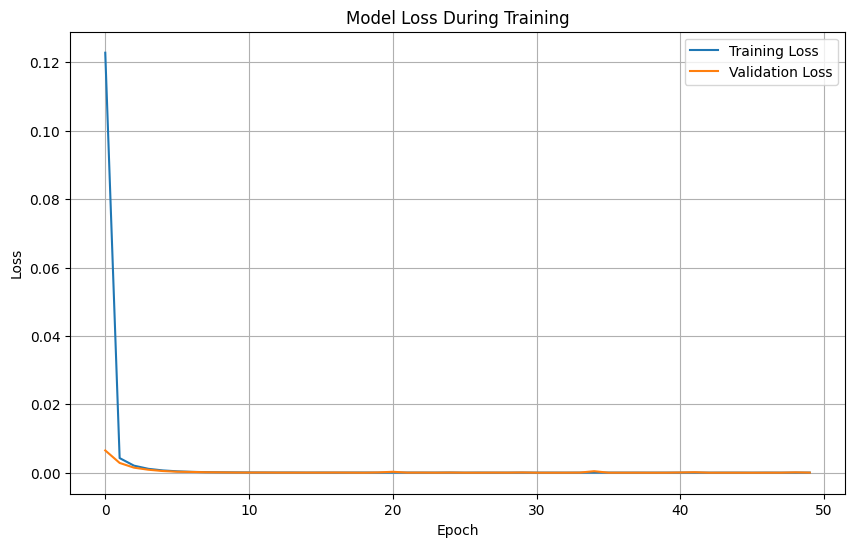

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Load and prepare the data
fraud_data = pd.read_csv('../data/fraud_data.csv')

# Define features and target
feature_columns = ['purchase_value', 'age', 'signup_time', 'purchase_time', 'source', 'browser', 'sex', 'ip_address']
target_column = 'class'

# Convert categorical variables to numeric
categorical_features = ['source', 'browser', 'sex']
fraud_data = pd.get_dummies(fraud_data, columns=categorical_features)

# Convert timestamp columns to numeric (seconds since epoch)
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time']).astype(np.int64) // 10**9
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time']).astype(np.int64) // 10**9

# Hash the ip_address
fraud_data['ip_address'] = pd.util.hash_array(fraud_data['ip_address'].values)

# Create feature matrix X and target vector y
X = fraud_data.drop(['class', 'user_id', 'device_id'], axis=1)
y = fraud_data['class']

# Split the data
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_f)
X_test_scaled = scaler.transform(X_test_f)

# Autoencoder architecture
autoencoder = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_f.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(X_train_f.shape[1], activation='linear')
])

# Compile and train
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

# Calculate reconstruction error for training data
train_predictions = autoencoder.predict(X_train_scaled)
train_mse = np.mean(np.power(X_train_scaled - train_predictions, 2), axis=1)

# Calculate reconstruction error for test data
test_predictions = autoencoder.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - test_predictions, 2), axis=1)

# Set threshold for anomaly detection (95th percentile of training reconstruction error)
threshold = np.percentile(train_mse, 95)

# Make predictions
y_pred_train = (train_mse > threshold).astype(int)
y_pred_test = (test_mse > threshold).astype(int)

# Calculate metrics
print("\nTraining Set Metrics:")
print("---------------------")
train_accuracy = accuracy_score(y_train_f, y_pred_train)
train_auc_roc = roc_auc_score(y_train_f, train_mse)
print(f'Accuracy: {train_accuracy:.4f}')
print(f'AUC-ROC Score: {train_auc_roc:.4f}')
print("\nClassification Report:")
print(classification_report(y_train_f, y_pred_train))

print("\nTest Set Metrics:")
print("---------------------")
test_accuracy = accuracy_score(y_test_f, y_pred_test)
test_auc_roc = roc_auc_score(y_test_f, test_mse)
print(f'Accuracy: {test_accuracy:.4f}')
print(f'AUC-ROC Score: {test_auc_roc:.4f}')
print("\nClassification Report:")
print(classification_report(y_test_f, y_pred_test))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()